# Pytorch入门实战（8）：小样本学习实现图片分类（Few-shot Learning, Meta Learning）

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iioSnail/pytorch_deep_learning_examples/blob/main/08_few_shot_learning.ipynb)

# 本文内容涉及知识点

1. [小样本学习的基本概念](https://blog.csdn.net/zhaohongfei_358/article/details/124057980)

# 本文内容

本文会使用Omniglot数据集训练一个孪生网络（相似网络），其可以用来判断两个图片的相似程度，通过该方式来实现小样本学习。

本文使用Omniglot的训练集来训练神经网络，使用其验证集来构造Support Set。本文会从验证集的每个类别中拿出5个样本作为Support Set，一共挑选10个类别，即为10-way 5-shot的小样本学习。

# 环境配置

本文所使用到的环境如下:

```
python==3.8.5
torch==1.10.2
torchvision==0.11.3
numpy==1.22.3
matplotlib==3.2.2
```

导入本文需要使用到的包：

In [1]:
import random

import torch
import torchvision
from torch import nn
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


# 加载数据集

我们这里使用Pytorch提供的`torchvision.datasets.Omniglot`的方法来加载数据集。

> 如果你用pytorch下载失败，可以使用[百度网盘链接](https://pan.baidu.com/s/1I3UGUjqEgGKVfxgZEt5H6w?pwd=v6pu)下载，然后解压到当前文件夹下，将`download`参数改为`False`即可

In [3]:
train_dataset = torchvision.datasets.Omniglot('./dataset', background=True, transform=transforms.ToTensor(), download=True)
validation_dataset = torchvision.datasets.Omniglot('./dataset', background=False, transform=transforms.ToTensor(), download=True)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./dataset/omniglot-py/images_background.zip to ./dataset/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./dataset/omniglot-py/images_evaluation.zip to ./dataset/omniglot-py


成功加载完数据集后我们来简单看一下：

In [4]:
image, target = train_dataset.__getitem__(0)
print("image size:", image.size())
print("target:", target)

image size: torch.Size([1, 105, 105])
target: 0


Omniglot数据集都是一张一张的灰度图，和MNIST手写数据集差不多。这个target就是用数字表示的类别，我也不知道对应成实际类别是什么，也不需要知道。

我们来简单绘制一张看一下：

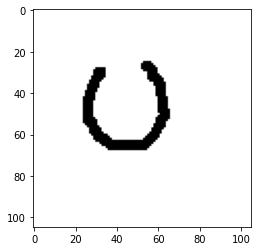

In [5]:
plt.imshow(image.squeeze(), cmap='gray')

# 数据处理

在孪生网络中，我们一次给到模型的是一对儿图片，然后让模型来区分这对儿图片是否是相同的类别。我们本章就需要来定义这么一个函数，来生成一批样本对儿，其中一半图片对儿是相同类别，另一半图片对儿是不同类别。

我们首先获取一下训练集中的所有target和所有labels：

In [6]:
all_targets = np.array([train_dataset.__getitem__(i)[1] for i in range(len(train_dataset))])
all_labels = np.array(list(set(all_targets)))

In [7]:
print("all_targets:", all_targets)
print("all_labels:", all_labels)

all_targets: [  0   0   0 ... 963 963 963]
all_labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 

准备好了这两个基础数据，我们就可以来构造我们的Sample函数了。其作用就是返回一个batch的图片对儿，其中一半是相同的类别，称为**正样本**，另一半是不同的类别，称为**负样本**。

In [8]:
def sample_batch(batch_size):
    """
    从train_dataset中sample一些数据对。一半正样本，一半负样本
    """

    # 选取二分之一个batch的labels作为正样本，这样就完成了正样本的构造。
    positive_labels = np.random.choice(all_labels, batch_size // 2)
    # 针对这些labels，每个选取两张相同类别的图片
    batch = []
    for label in positive_labels:
        labels_indexes = np.argwhere(all_targets == label)
        pair = np.random.choice(labels_indexes.flatten(), 2)
        batch.append((pair[0], pair[1], 1)) # 图片类别相同，所以target为1

    # 选取负样本，这次选取一个batch的labels，然后每个labels个选取一张图片。这样就完成了负样本的构造。
    negative_labels = np.random.choice(all_labels, batch_size)
    for sample1, sample2 in negative_labels.reshape(-1, 2):
        sample1 = np.random.choice(np.argwhere(all_targets == sample1).flatten(), 1)
        sample2 = np.random.choice(np.argwhere(all_targets == sample2).flatten(), 1)
        batch.append((sample1.item(), sample2.item(), 0)) # 图片类别不相同，所以target为0

    """
    完成上面的动作后，最终得到的batch如下：
        (734, 736, 1),
        (127, 132, 1),
        ...
        (859, 173, 0),
        ...
    其中前两个表示样本对对应在dataset中的index，1表示前两个样本是相同类别。0表示这两个样本为不同类别。
    接下来需要对其进行shuffle处理，然后从dataset中获取到对应数据，最终组成batch.
    """
    random.shuffle(batch)

    sample1_list = []
    sample2_list = []
    target_list = []
    for sample1, sample2, target in batch:
        sample1_list.append(train_dataset.__getitem__(sample1)[0])
        sample2_list.append(train_dataset.__getitem__(sample2)[0])
        target_list.append(target)
    sample1 = torch.stack(sample1_list)
    sample2 = torch.stack(sample2_list)
    targets = torch.LongTensor(target_list)
    return sample1, sample2, targets

完成sample函数后，我们来简单试一下：

In [9]:
sample1, sample2, targets = sample_batch(16)

In [10]:
print("sample1:", sample1.size())
print("sample2:", sample1.size())
print("targets:", targets)

sample1: torch.Size([16, 1, 105, 105])
sample2: torch.Size([16, 1, 105, 105])
targets: tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1])


其中`sample1[0]`和`smaple2[0]` 是一对儿，`targets[0]`是它们的标签，表示它们是否是相同类别。

准备好数据后，我们接下来开始构建模型：

# 模型构建

我们需要构建的模型也很简单，模型的功能就是输入两张图片，输出这两张图片是否为同一个类别。由于是二分类问题，所以我们最后的值通过Sigmoid处理一下：

In [11]:
class SimilarityModel(nn.Module):

    def __init__(self):
        super(SimilarityModel, self).__init__()

        # 定义一个卷积层，用于特征提取。
        self.conv = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
        )

        # 定义一个线性层，用来判断两张图片是否为同一类别
        self.sim = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2592, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, sample1, sample2):
        # 使用卷积层提取sample1的特征
        sample1_features = self.conv(sample1)
        # 使用卷积层提取sample2的特征
        sample2_features = self.conv(sample2)
        # 将 |sample1-sample2| 的结果送给线性层，判断它们的相似度。
        return self.sim(torch.abs(sample1_features - sample2_features))

In [12]:
model = SimilarityModel()
model = model.to(device)

模型定义完后，我们来简单的尝试一下：

In [13]:
model(sample1.to(device), sample2.to(device))

tensor([[0.5004],
        [0.5005],
        [0.5003],
        [0.5005],
        [0.5000],
        [0.5004],
        [0.5005],
        [0.5004],
        [0.5000],
        [0.5004],
        [0.5006],
        [0.5001],
        [0.5002],
        [0.5003],
        [0.5000],
        [0.5002]], device='cuda:0', grad_fn=<SigmoidBackward0>)

可以看到，由于模型还未训练，所以输出的值都在50%左右。

# 训练模型

接下来开始训练模型，和普通的二分类问题差别不算很大。

In [14]:
model = model.train()

In [15]:
criteria = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
batch_size = 512
# 如果500次迭代loss都没有下降，那么就停止训练
early_stop = 1500
# 记录最小的一次loss值
min_loss = 100.
# 记录下上一次最小的loss是哪一次
last_episode = 0
# 无线更新参数，直到loss不再下降为止
for episode in range(100000):
    # 使用sample_batch函数sample出一组数据，包含一半正样本，一半负样本
    sample1, sample2, targets = sample_batch(batch_size)
    # 将数据送入模型，判断是否为同一类别
    outputs = model(sample1.to(device), sample2.to(device))
    # 将模型的结果丢给BCELoss计算损失
    loss = criteria(outputs.flatten(), targets.to(device).float())
    loss.backward()
    # 更新模型参数
    optimizer.step()
    optimizer.zero_grad()

    # 如果本次损失比之前的小，那么记录一下
    if loss < min_loss:
        min_loss = loss.item()
        last_episode = episode
        torch.save(model, 'best_model.pt')

    # 如果连续{early_stop}次loss都没有减小，那么就停止训练
    if episode - last_episode > early_stop:
        break

    # 每50个episode打印一下日志
    if episode % 50 ==  0:
        print(f"episode {episode}, loss {loss}")

print("Finish Training.")

episode 0, loss 0.6931208372116089
episode 50, loss 0.6730687618255615
episode 100, loss 0.6514454483985901
episode 150, loss 0.6112750768661499
episode 200, loss 0.5643270015716553
episode 250, loss 0.4998775124549866
episode 300, loss 0.562949001789093
episode 350, loss 0.49458998441696167
episode 400, loss 0.4829554855823517
episode 450, loss 0.50950688123703
episode 500, loss 0.44546687602996826
episode 550, loss 0.4880187511444092
episode 600, loss 0.43081381916999817
episode 650, loss 0.42522192001342773
episode 700, loss 0.43799975514411926
episode 750, loss 0.4290987253189087
episode 800, loss 0.400988906621933
episode 850, loss 0.43764418363571167
episode 900, loss 0.3570705056190491
episode 950, loss 0.40238815546035767
episode 1000, loss 0.42024746537208557
episode 1050, loss 0.39611750841140747
episode 1100, loss 0.3548458516597748
episode 1150, loss 0.31902915239334106
episode 1200, loss 0.30719077587127686
episode 1250, loss 0.3704574704170227
episode 1300, loss 0.3936080

KeyboardInterrupt: ignored

# 模型验证

验证前先加载一下之前最好的模型：

In [17]:
model = torch.load('best_model.pt')
model = model.to(device)

接下来我们来验证下我们模型的表现。我们使用上面构造好的validation_dataset。在validation_dataset中，全都是模型之间没有见过的类别，可不是没有见过的图片哦，连这个类别它都没有见过。不信你可以到`dataset/images_evaluation`这个目录下表看看那。

我们先来看下验证集中的类别情况：

In [18]:
all_targets = np.array([validation_dataset.__getitem__(i)[1] for i in range(len(validation_dataset))])
all_labels = np.array(list(set(all_targets)))

In [19]:
print("sample size:", len(all_targets))
print("all_targets:", all_targets)
print("all_labels:", all_labels)

sample size: 13180
all_targets: [  0   0   0 ... 658 658 658]
all_labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 2

可以看到，在验证集中我们一共有13180个数据，有658个类别，每个类别有20个样本。我们为每个类别选取5个样本作为support set供模型参考，剩下的15个作为验证集来验证模型的表现。

如果对这658个类别全部都做预测的话，相当于我们的任务是一个658-way 5-shot的任务。这样不仅预测过程会非常慢，并且准确率也会非常低，所以上面的简单模型就应付不了了。为了简单期间，我们这里裁剪一下，就使用10个类别来验证我们的模型：

In [20]:
all_targets = all_targets[all_targets < 10]
all_labels = all_labels[:10]
print("sample size:", len(all_targets))
print("all_targets:", all_targets)
print("all_labels:", all_labels)

sample size: 200
all_targets: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
all_labels: [0 1 2 3 4 5 6 7 8 9]


In [21]:
support_set = []
validation_set = []
# 遍历所有的标签，每个标签选取前5个作为support set，后面的作为验证数据
for label in all_labels:
    label_indexes = np.argwhere(all_targets == label)
    support_set.append((label_indexes[:5].flatten().tolist()))
    validation_set += label_indexes[5:].flatten().tolist()

In [22]:
print("support set:", support_set[:5])
print("validation set:", validation_set[:5])
print("validation size:", len(validation_set))

support set: [[0, 1, 2, 3, 4], [20, 21, 22, 23, 24], [40, 41, 42, 43, 44], [60, 61, 62, 63, 64], [80, 81, 82, 83, 84]]
validation set: [5, 6, 7, 8, 9]
validation size: 150


我们接下来需要定义一个预测函数，其给定一个图片，输出该图片的target。该函数的思路为：让该图片与support set里的所有类别都比较一下，看看与谁的相似度最高，那么该图片就是什么类别。由于一个类别有5张图片，我们可以通过取平均的方式来得到该图片为该类别的可能性。

In [23]:
def predict(image):
    sim_list = [] # 存储image与每个类别的相似度
    # 一个类别一个类别的遍历，indexes存储的就是当前类别的5张图片的index
    for indexes in support_set:
        # 去validation_dataset中找出index对应的图片tensor
        tensor_list = []
        for i in indexes:
            tensor_list.append(validation_dataset[i][0])
        support_tensor = torch.stack(tensor_list)
        # 拿到该类别的5个图片后，就可以送给模型求image与它们的相似程度了，最后求个平均
        sim = model(image.repeat(5, 1, 1, 1).to(device), support_tensor.to(device)).mean()
        sim_list.append(sim)

    # 找出其中相似程度最高的那个，它就是预测结果
    result_index = torch.stack(sim_list).argmax().item()
    return all_labels[result_index]

我们来试下predict函数：

In [24]:
predict(validation_dataset.__getitem__(validation_set[0])[0])

0

最后我们一个个的对验证集的数据进行验证，计算正确率。

In [25]:
total = 0
total_correct = 0

# 由于验证集太大，为了更快的看到效果，我们验证前，将validation_set打乱一下再验证
random.shuffle(validation_set)
progress = tqdm(validation_set)

for i in progress:
    image, label = validation_dataset.__getitem__(i)
    predict_label = predict(image)

    total += 1
    if predict_label == label:
        total_correct += 1

    progress.set_postfix({
            "accuracy": str("%.3f" % (total_correct / total))
        })

100%|██████████| 150/150 [00:06<00:00, 21.66it/s, accuracy=0.700]


In [26]:
print("Accuracy:", total_correct / total)

Accuracy: 0.7


最终，在这150个验证数据中，我们取得了70%的正确率，不算太高，但至少能说明模型是有效果的。

> 由于模型结构是我拍脑袋随便想的，而且比较小，所以如果用全部的658个类别做预测的话，效果会比较差，正确率大概只有15%左右，感兴趣的朋友可以尝试一下，并且优化模型。